In [3]:
# Importamos las librerias necesarias
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dataframe_image as dfi
import os
import seaborn as sns
from IPython.display import display, Markdown, Latex

In [4]:
# Definiciones del script

# Directorio de imagenes
dirImg = './imagenes'

# CSV
csv1 = 'data.csv'

In [5]:
# Creamos el directorio de imagenes
if not os.path.exists(dirImg):
	os.mkdir(dirImg)
else :
	os.system("rm -r " + dirImg)
	os.mkdir(dirImg)

In [6]:
# Obtenemos los datos del archivo CSV para un dataset
dataset1 = pd.read_csv(csv1, sep=',', header=None)

# Agregamos los nombres de las columnas
dataset1.columns = ['Flag', 'Value', 'Diff', 'nTrap', 'Process', 'Time']

# Remove column Flag
dataset1 = dataset1.drop('Flag', axis=1)

print("Total rows: {0}".format(len(dataset1)))

Total rows: 27040


In [5]:
# Eliminamos los valores donde el overhead o time es negativo
#dataset1 = dataset1[dataset1['Time'] >= 0]
#print("Total rows: {0}".format(len(dataset1)))

In [7]:
# Obtenemos los valores unicos de la columna Process y N
process = dataset1['Process'].unique()
nTrap = dataset1['nTrap'].unique()

process = sorted(process)
nTrap = sorted(nTrap)

datasetsByCore = []

for p in process:
	for n in nTrap:
		datasetsByCore.append(dataset1[(dataset1['Process'] == p) & (dataset1['nTrap'] == n)])

print(len(process) * len(nTrap))
print(len(datasetsByCore))

832
832


In [41]:
finalData = []

min_process = dataset1['Process'].min()

ref_dataset = dataset1[dataset1['Process'] == min_process]

ref_times = ref_dataset.groupby('nTrap')['Time'].max()

for (nTrap_value, process_value), group in dataset1.groupby(['nTrap', 'Process']):

	max_time = group['Time'].max()

	ref_time = ref_times.get(nTrap_value, None)

	if ref_time and max_time:
		speedup = ref_time / max_time
		efficiency = speedup / process_value if process_value != 0 else 0
	else:
		speedup = None
		efficiency = None

	group = group[group['Diff'] != -1]

	error = abs(group['Diff'].min())
	quality = 1 / (max_time * error) if max_time and error else None

	finalData.append([process_value, nTrap_value, max_time, ref_time, speedup, efficiency, error, quality])

final_df = pd.DataFrame(finalData, columns=['Process', 'nTrap', 'MaxTime', 'RefTime', 'Speedup', 'Efficiency', 'Error', 'Quality'])

In [46]:
# Ajustamos algun dato que falle con la media del valor de arriba y del de abajo

final_df.loc[(final_df['Process'] == 44) & (final_df['nTrap'] == 1), 'Efficiency'] = 0.022222 
final_df.loc[(final_df['Process'] == 44) & (final_df['nTrap'] == 1), 'Speedup'] = 1
final_df.loc[(final_df['Process'] == 8) & (final_df['nTrap'] == 1), 'Efficiency'] = 0.273810
final_df.loc[(final_df['Process'] == 8) & (final_df['nTrap'] == 1), 'Speedup'] = 2.25
print(final_df.loc[(final_df['Process'] == 8) & (final_df['nTrap'] == 1), 'Efficiency']) # (0.333333 + 0.214286)  / 2 = 0.273810 
print(final_df.loc[(final_df['Process'] == 8) & (final_df['nTrap'] == 1), 'Speedup']) # (3 + 1.5) / 2 = 2.25

7    0.27381
Name: Efficiency, dtype: float64
7    2.25
Name: Speedup, dtype: float64


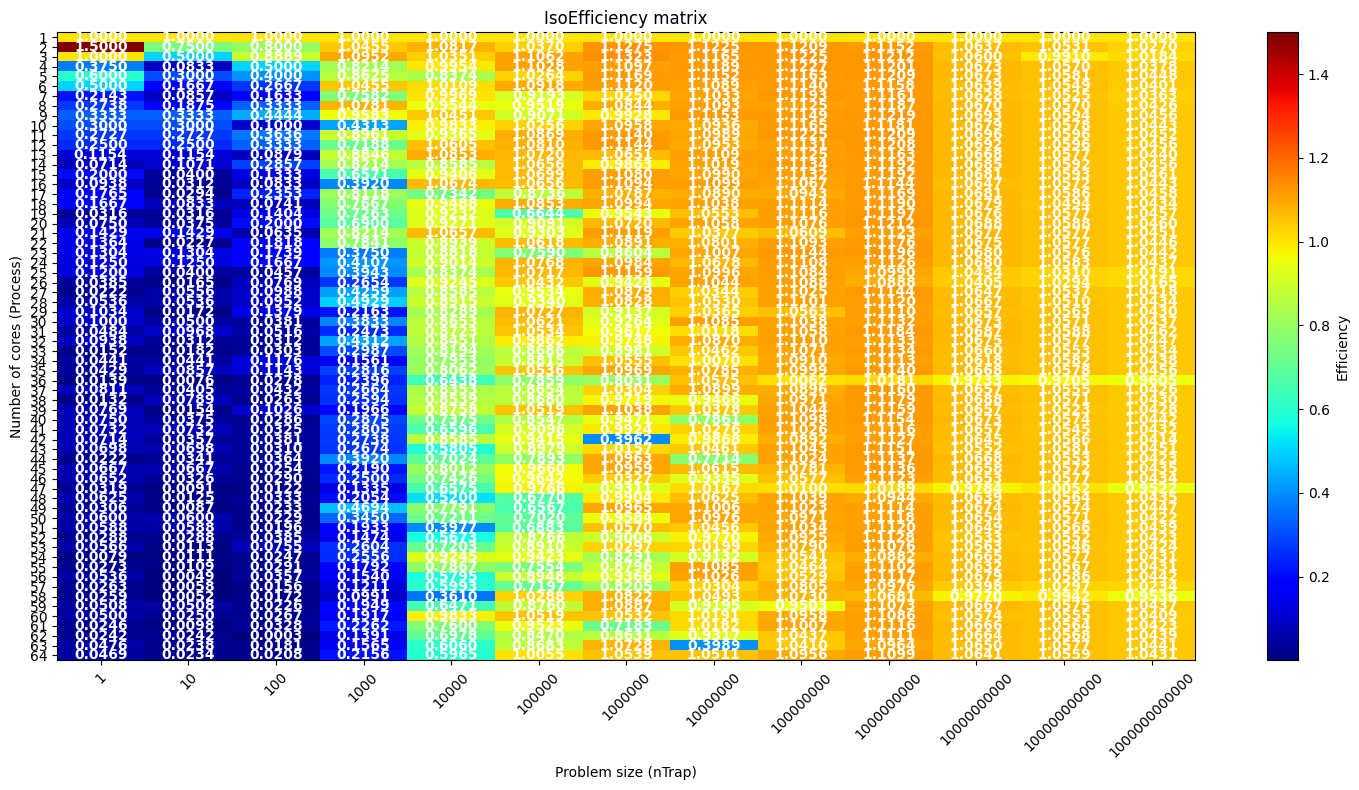

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

efficiency_matrix = final_df.pivot(index='Process', columns='nTrap', values='Efficiency')

plt.figure(figsize=(15, 8))

cmap = plt.get_cmap('jet')

cax = plt.imshow(efficiency_matrix, aspect='auto', cmap=cmap, interpolation='nearest')

plt.colorbar(cax, label='Efficiency')
plt.title("IsoEfficiency matrix")
plt.xlabel("Problem size (nTrap)")
plt.ylabel("Number of cores (Process)")

plt.xticks(range(len(efficiency_matrix.columns)), efficiency_matrix.columns, rotation=45)
plt.yticks(range(len(efficiency_matrix.index)), efficiency_matrix.index)

for i in range(len(efficiency_matrix.index)):
	for j in range(len(efficiency_matrix.columns)):
		efficiency_value = efficiency_matrix.iat[i, j]
		if not pd.isnull(efficiency_value):
			plt.text(j, i, f'{efficiency_value:.4f}', ha='center', va='center', color='white', fontweight='bold')

plt.tight_layout()

plt.savefig(f'{dirImg}/iso_efficiency_matrix.png')

plt.show()


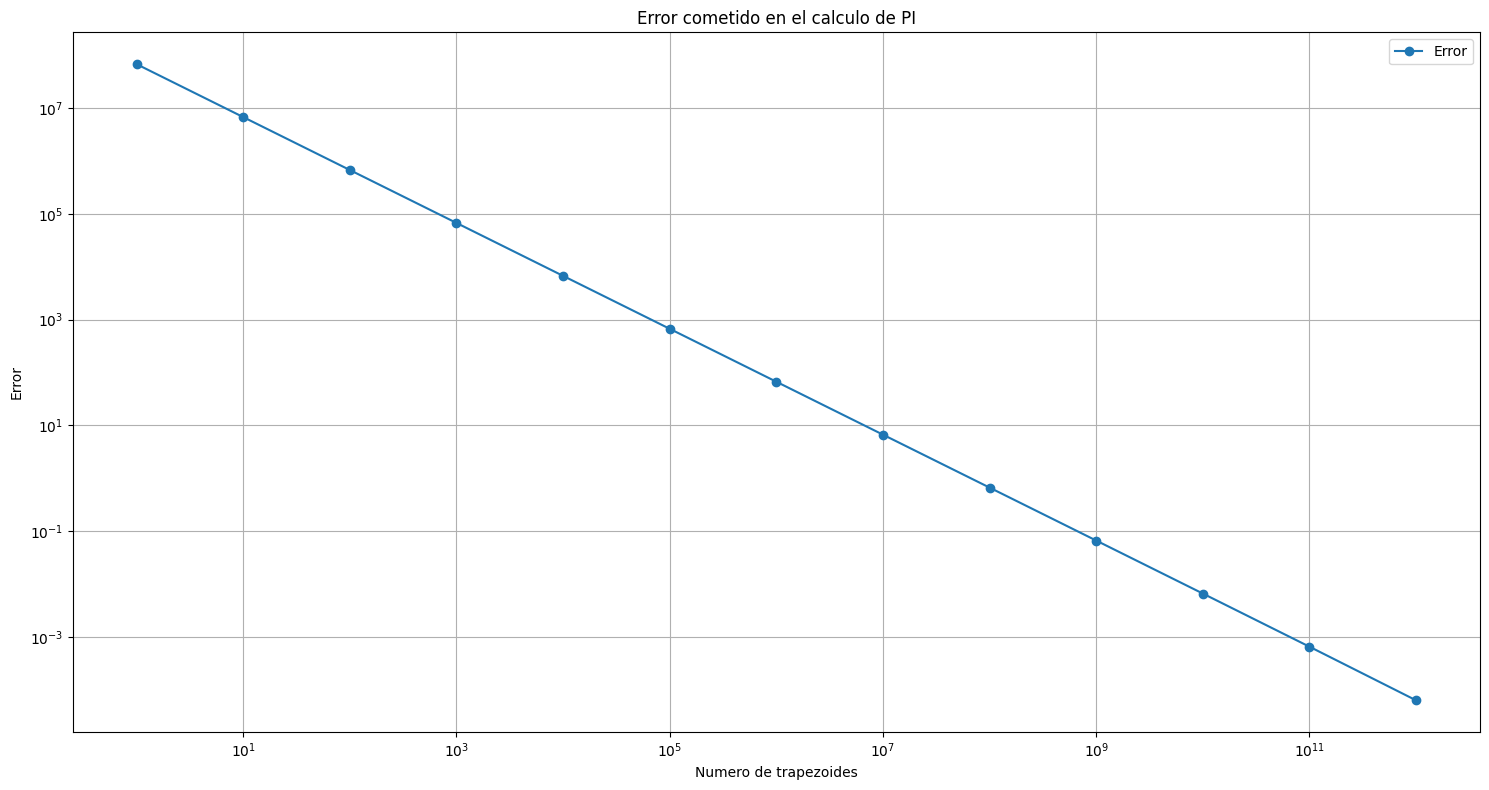

In [11]:
# Graficamos el error cometido en el calculo de PI para cada valor de N

# Filtramos los los valores que tengan un valor de -1 en la columna Diff y para el proceso 1
tempData = final_df[(final_df['Process'] == 64)]

# Valores de N
xValues = tempData['nTrap']
yValues = tempData['Error']

plt.figure(figsize=(15, 8))

plt.plot(xValues, yValues, marker='o', label='Error')

plt.xscale('log')
plt.yscale('log')

plt.title('Error cometido en el calculo de PI')
plt.xlabel('Numero de trapezoides')
plt.ylabel('Error')

plt.legend()
plt.grid()
plt.tight_layout()

plt.savefig(dirImg + '/error.png')

plt.show()


In [21]:
# Dame los datos de final_df para Process = 9 y 64
final_df_9 = final_df[final_df['Process'] == 1]
final_df_64 = final_df[final_df['Process'] == 64]

display(final_df_9)
display(final_df_64)

,Process,nTrap,MaxTime,RefTime,Speedup,Efficiency,Error,Quality
0,1,1,0.000003,0.000003,1.0,1.0,6.710886e+07,0.004967
64,1,10,0.000003,0.000003,1.0,1.0,6.710681e+06,0.049672
128,1,100,0.000008,0.000008,1.0,1.0,6.710474e+05,0.186276
192,1,1000,0.000069,0.000069,1.0,1.0,6.710672e+04,0.215966
256,1,10000,0.000649,0.000649,1.0,1.0,6.711062e+03,0.229596
320,1,100000,0.006564,0.006564,1.0,1.0,6.710589e+02,0.227023
384,1,1000000,0.066034,0.066034,1.0,1.0,6.710799e+01,0.225662
448,1,10000000,0.646371,0.646371,1.0,1.0,6.709963e+00,0.230567
512,1,100000000,6.437545,6.437545,1.0,1.0,6.707556e-01,0.231588
576,1,1000000000,64.207758,64.207758,1.0,1.0,6.701446e-02,0.232404


,Process,nTrap,MaxTime,RefTime,Speedup,Efficiency,Error,Quality
63,64,1,0.000001,0.000003,3.000000,0.046875,6.710886e+07,0.014901
127,64,10,0.000002,0.000003,1.500000,0.023438,6.710681e+06,0.074508
191,64,100,0.000006,0.000008,1.333333,0.020833,6.710474e+05,0.248368
255,64,1000,0.000005,0.000069,13.800000,0.215625,6.710672e+04,2.980327
319,64,10000,0.000017,0.000649,38.176471,0.596507,6.711062e+03,8.765160
383,64,100000,0.000102,0.006564,64.352941,1.005515,6.710589e+02,14.609628
447,64,1000000,0.000979,0.066034,67.450460,1.053913,6.710799e+01,15.220996
511,64,10000000,0.009609,0.646371,67.267249,1.051051,6.709963e+00,15.509639
575,64,100000000,0.091806,6.437545,70.121179,1.095643,6.707556e-01,16.239199
639,64,1000000000,0.903920,64.207758,71.032567,1.109884,6.701446e-02,16.508268


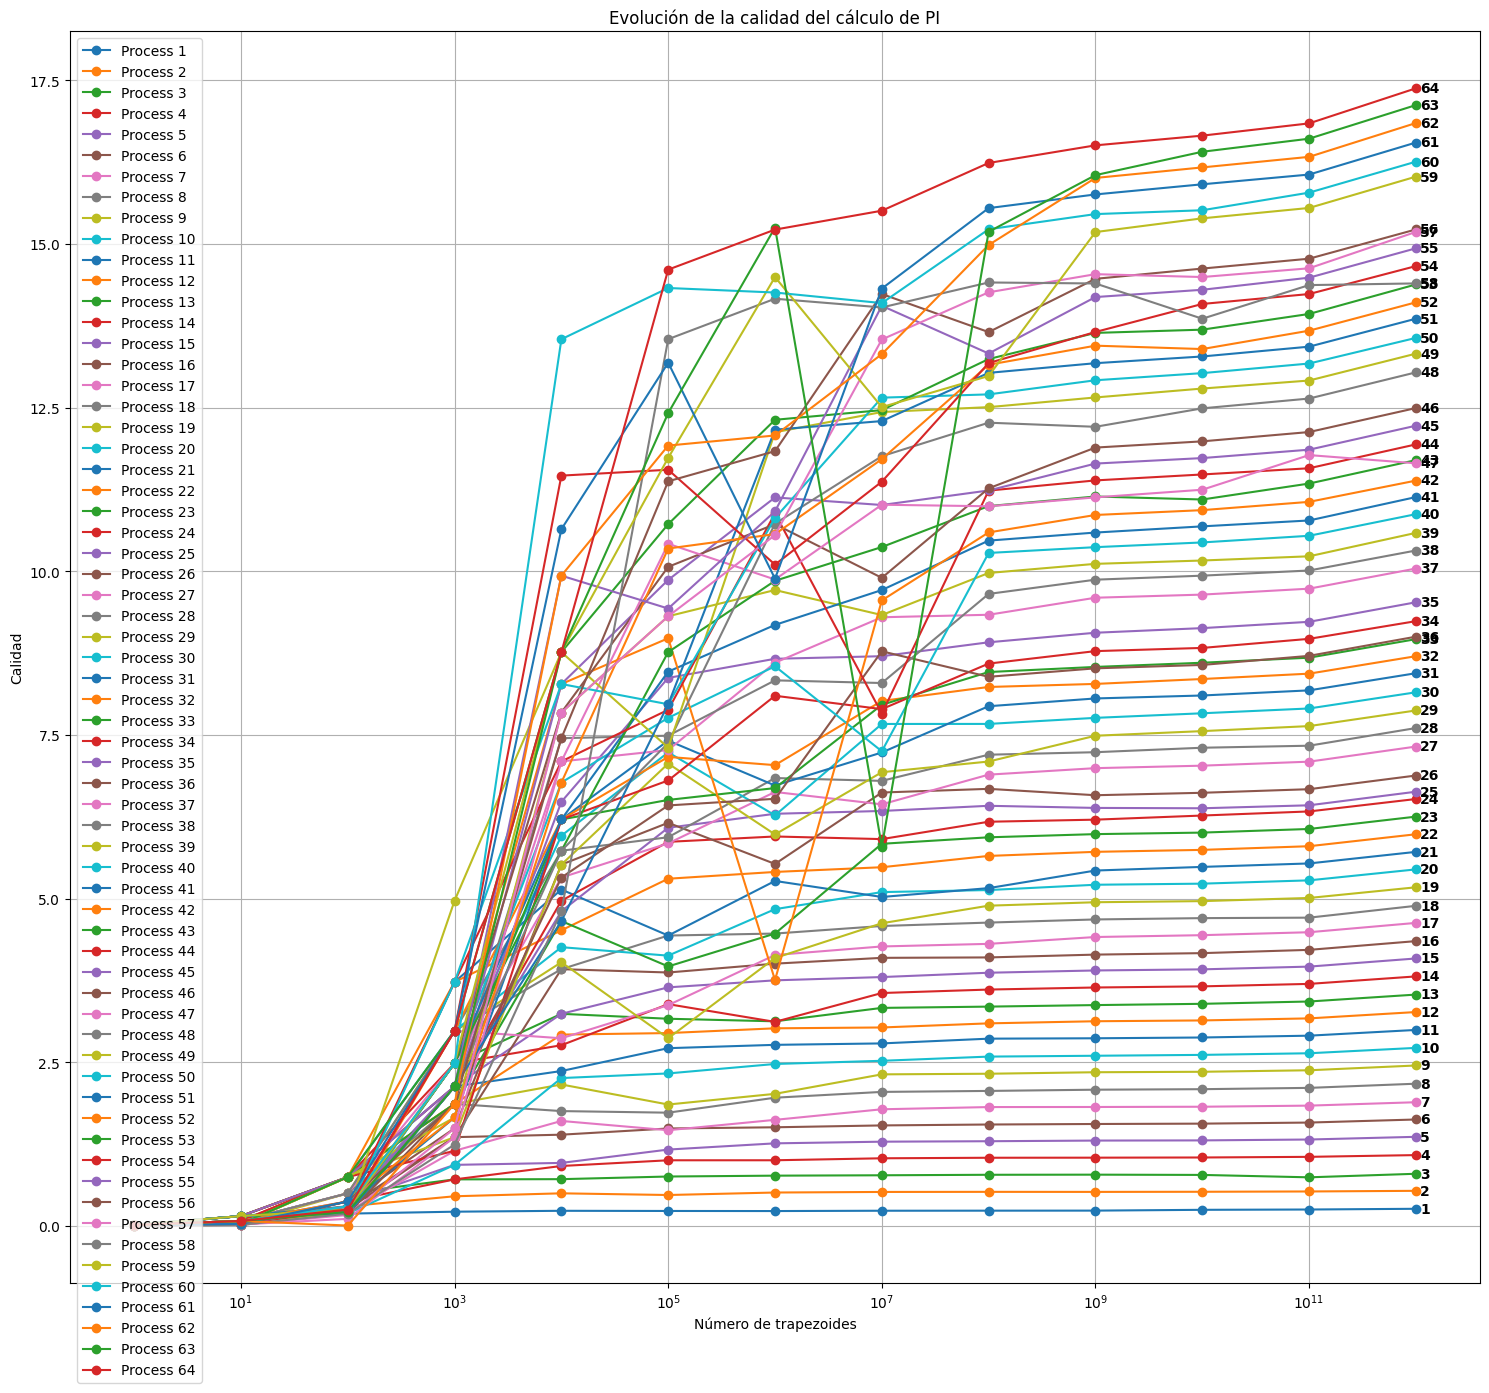

In [14]:
plt.figure(figsize=(15, 15))

for i in range(len(process)):
    tempData = final_df[(final_df['Process'] == process[i])]
    xValues = tempData['nTrap']
    yValues = tempData['Quality']

    # Graficar la línea para cada número de procesos
    plt.plot(xValues, yValues, marker='o', label='Process ' + str(process[i]))

    # Agregar el número de procesos un poco a la derecha del punto final
    plt.text(xValues.iloc[-1] * 1.1, yValues.iloc[-1], str(process[i]), 
             ha='left', va='center', fontweight='bold', fontsize=10)

plt.xscale('log')

plt.title('Evolución de la calidad del cálculo de PI')
plt.xlabel('Número de trapezoides')
plt.ylabel('Calidad')

plt.legend()
plt.grid()
plt.tight_layout()

plt.savefig(dirImg + '/quality.png')

plt.show()


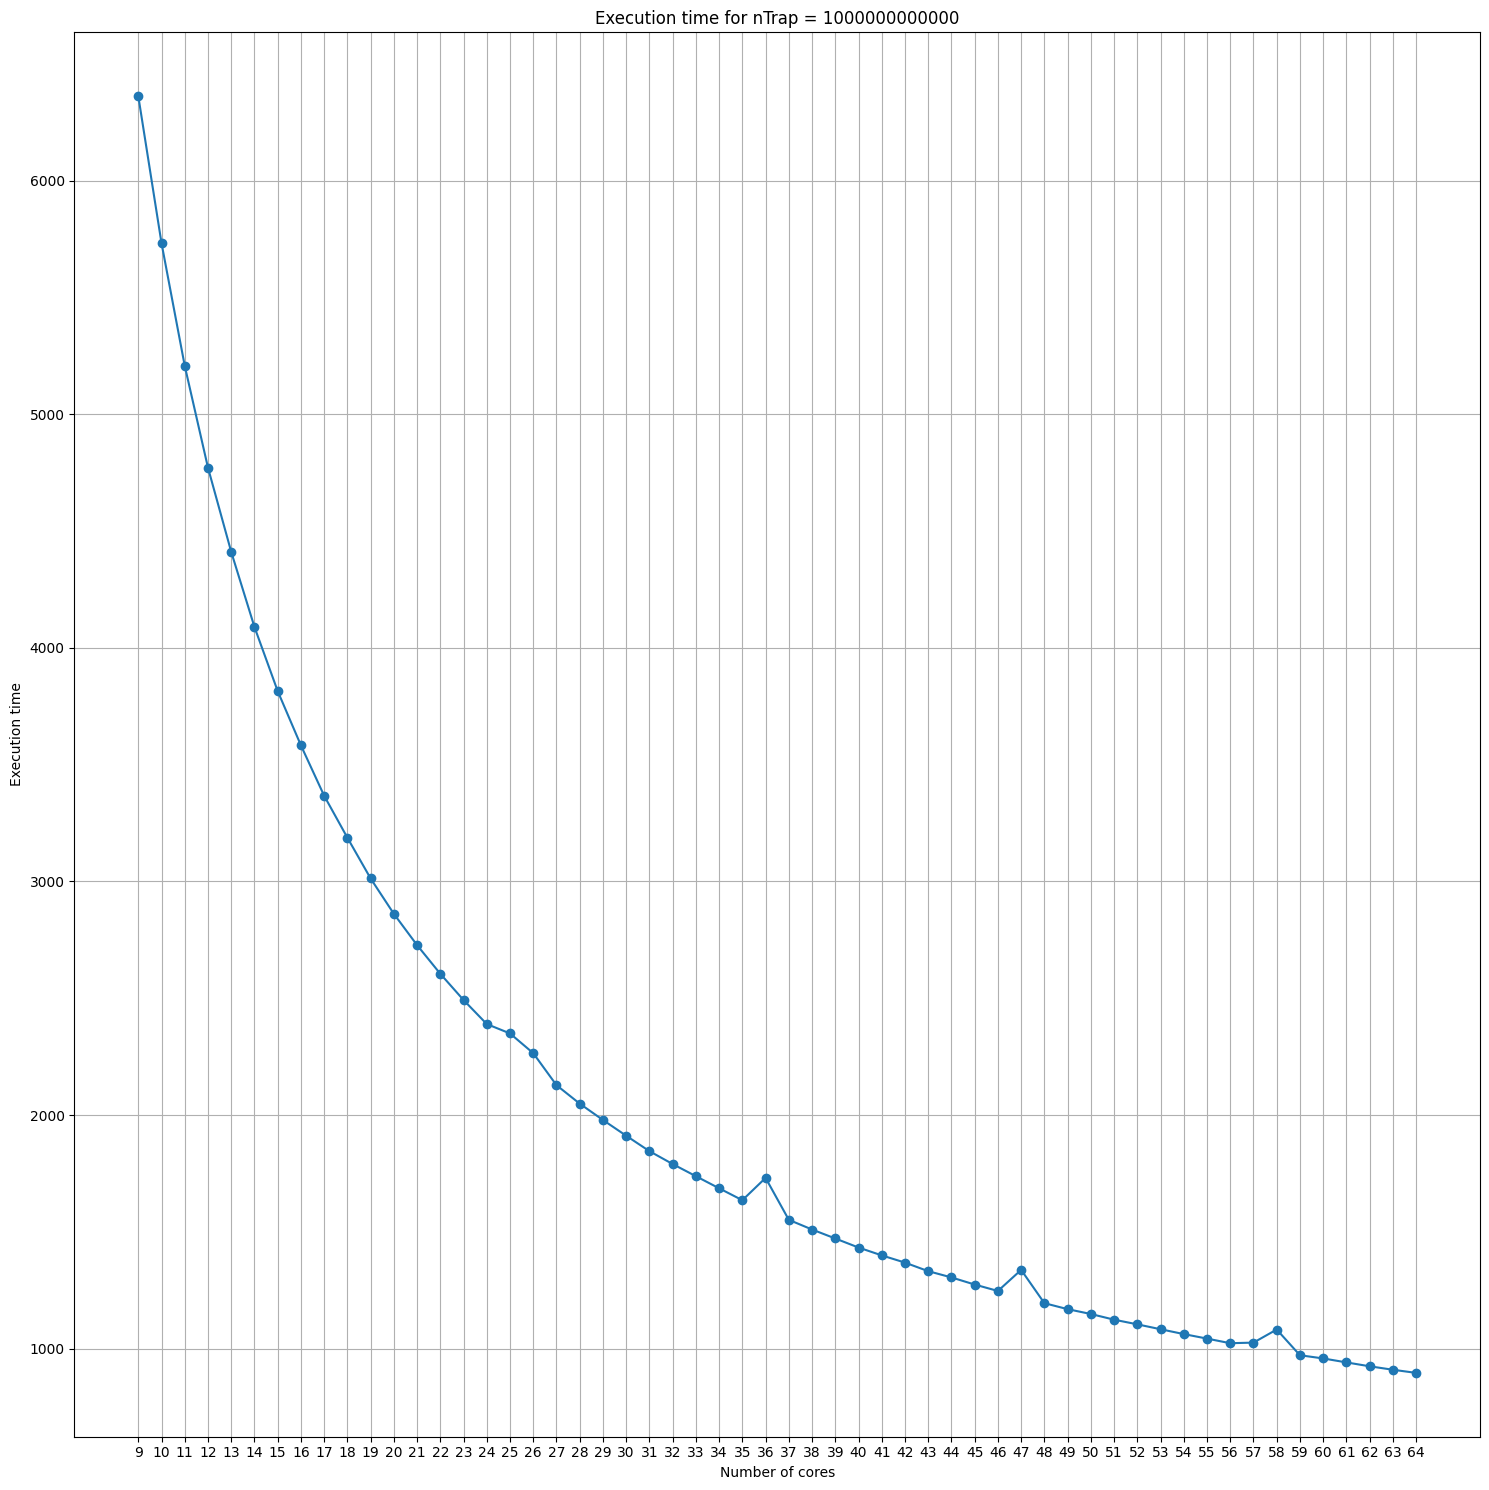

In [30]:
plt.figure(figsize=(15, 15))

maxN = final_df['nTrap'].max()

xvalues = range(len(process))
yvalues = final_df[final_df['nTrap'] == maxN]['MaxTime']

plt.plot(xvalues, yvalues, marker='o')

plt.title('Execution time for nTrap = ' + str(maxN))
plt.xlabel('Number of cores')
plt.ylabel('Execution time')

plt.xticks(xvalues, process)

plt.grid()
plt.tight_layout()

plt.savefig(dirImg + '/execution_time.png')

plt.show()

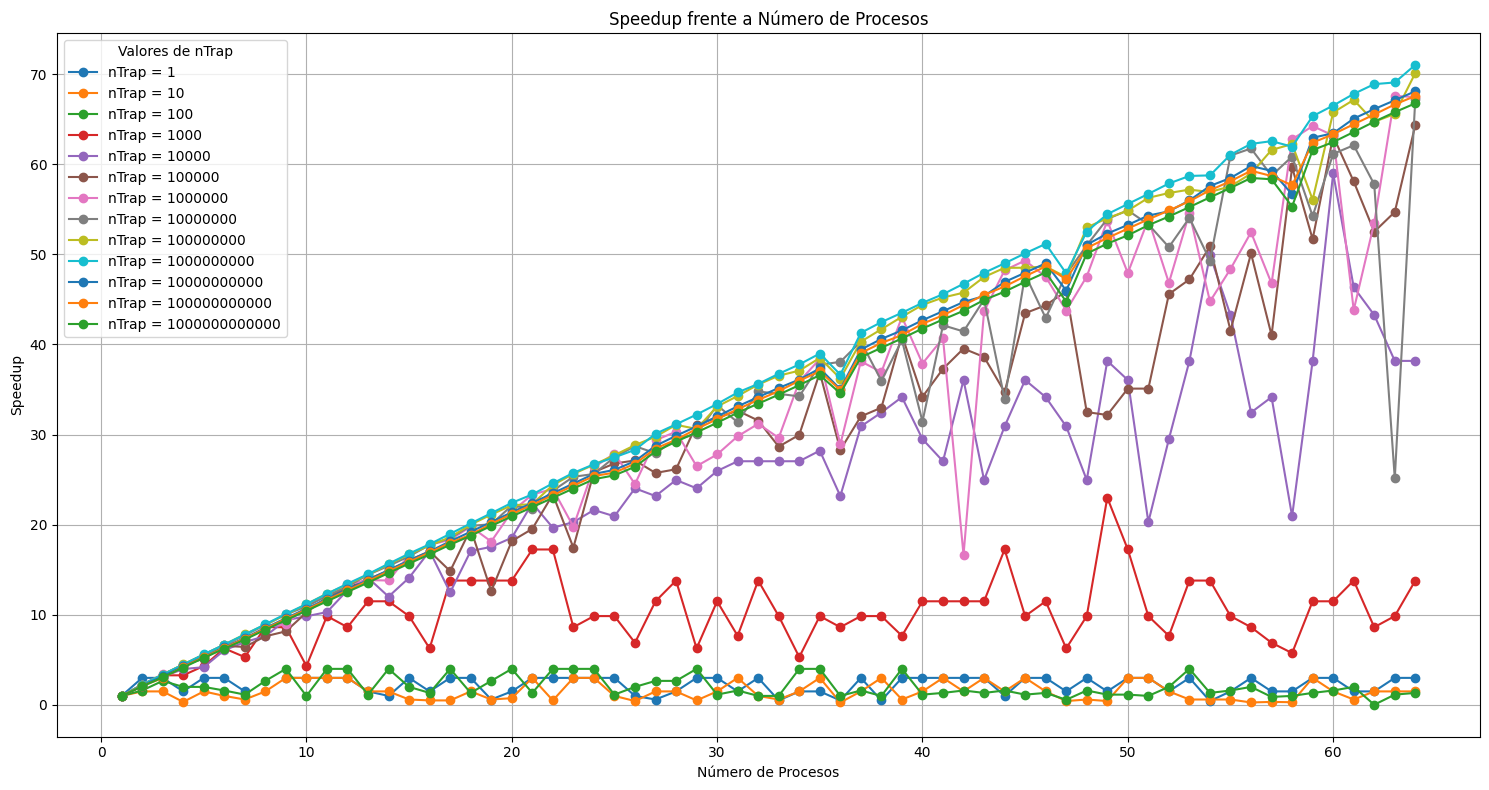

In [15]:
plt.figure(figsize=(15, 8))

# Obtener los valores únicos de nTrap para crear líneas por color
nTrap_values = final_df['nTrap'].unique()

for n in nTrap_values:
    # Filtrar los datos para cada valor de nTrap
    tempData = final_df[final_df['nTrap'] == n]
    
    # Extraer valores de los ejes
    xValues = tempData['Process']
    yValues = tempData['Speedup']
    
    # Graficar con un color diferente para cada nTrap
    plt.plot(xValues, yValues, marker='o', label=f'nTrap = {n}')

# Configurar etiquetas y título
plt.title('Speedup frente a Número de Procesos')
plt.xlabel('Número de Procesos')
plt.ylabel('Speedup')

# Añadir leyenda y cuadrícula
plt.legend(title='Valores de nTrap', loc='upper left')
plt.grid(True)
plt.tight_layout()

# Guardar y mostrar
plt.savefig(dirImg + '/speedup_vs_procs.png')
plt.show()


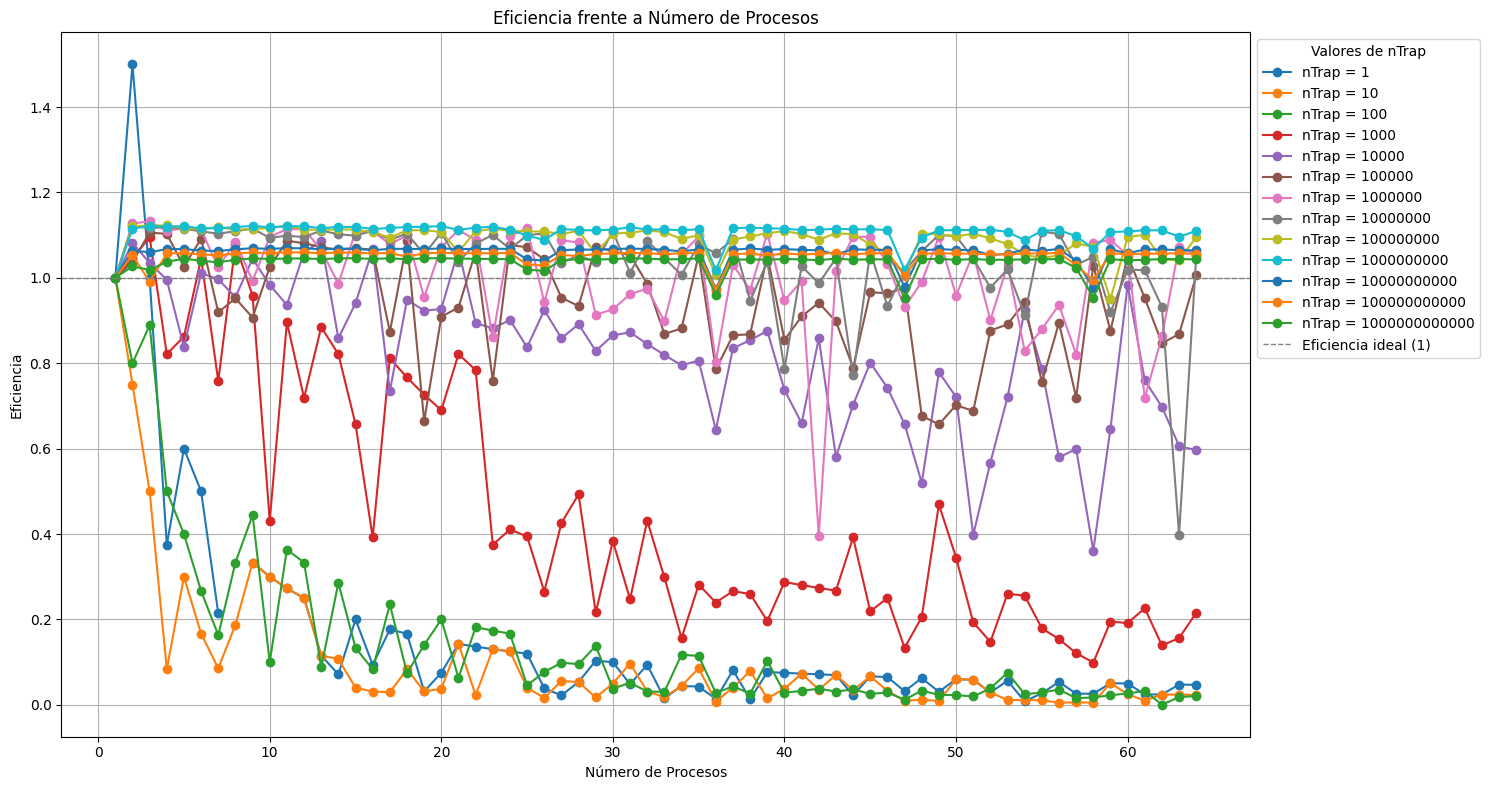

In [17]:
plt.figure(figsize=(15, 8))

# Valores únicos de nTrap para colorear cada curva según el tamaño del problema
nTrap_values = final_df['nTrap'].unique()

for n in nTrap_values:
    # Filtrar los datos para cada valor de nTrap
    tempData = final_df[final_df['nTrap'] == n]
    
    # Extraer valores de los ejes
    xValues = tempData['Process']
    yValues = tempData['Efficiency']
    
    # Graficar cada curva de eficiencia para el valor de nTrap
    plt.plot(xValues, yValues, marker='o', label=f'nTrap = {n}')

# Agregar una línea horizontal en eficiencia = 1
plt.axhline(y=1, color='gray', linestyle='--', linewidth=1, label='Eficiencia ideal (1)')

# Configuración del título y etiquetas de ejes
plt.title('Eficiencia frente a Número de Procesos')
plt.xlabel('Número de Procesos')
plt.ylabel('Eficiencia')

# Añadir leyenda en la parte superior, fuera de la gráfica
plt.legend(title='Valores de nTrap', loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()

# Guardar y mostrar la gráfica
plt.savefig(dirImg + '/efficiency_vs_procs.png')
plt.show()

